This notebook was adapted from the demo for UrbanAccess provided by UrbanSim: https://github.com/UDST/urbanaccess

In [1]:
import matplotlib
matplotlib.use('agg')  # allows notebook to be tested in Travis

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import time

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network
import pandana as pdna
import osmnx as ox

%matplotlib inline

## Set the study area

In [2]:
# Get the county geometries using OSMnx

counties = ['Alameda,CA', 'Contra Costa, CA']
counties_gdf = ox.geocode_to_gdf(counties)
counties_gdf

geometry  bbox_north  bbox_south  \
0  POLYGON ((-122.37384 37.88364, -122.37381 37.8...   37.906690   37.453950   
1  POLYGON ((-122.44148 37.96062, -122.44138 37.9...   38.104512   37.718479   

    bbox_east   bbox_west   place_id  osm_type  osm_id        lat         lon  \
0 -121.469090 -122.373843  282405691  relation  396499  37.609029 -121.899142   
1 -121.534272 -122.441484  282414318  relation  396462  37.903481 -121.917535   

                                     display_name     class            type  \
0       Alameda County, California, United States  boundary  administrative   
1  Contra Costa County, California, United States  boundary  administrative   

   importance  
0    0.766398  
1    0.860293

In [3]:
# Extract the bounding box for the two-county area formatted for use with UrbanAccess

north = counties_gdf["bbox_north"].max()
south = counties_gdf["bbox_south"].min()
east = counties_gdf["bbox_east"].max()
west = counties_gdf["bbox_west"].min()

region_bbox = (west, south, east, north)
region_bbox

(-122.441484, 37.4539501, -121.4690903, 38.1045118)

## Build Transit Network

In [4]:
# Set default options in UrbanAccess

settings.to_dict()

{'data_folder': 'data',
 'logs_folder': 'logs',
 'log_file': True,
 'log_console': False,
 'log_name': 'urbanaccess',
 'log_filename': 'urbanaccess',
 'txt_encoding': 'utf-8',
 'gtfs_api': {'gtfsdataexch': 'http://www.gtfs-data-exchange.com/api/agencies?format=csv'}}

In [5]:
# Create a feeds object for storing GTFS feeds

feeds.to_dict()

{'gtfs_feeds': {}}

In [6]:
# Add the BART GTFS feed
# Information at https://www.bart.gov/schedules/developers/gtfs

feeds.add_feed(add_dict={'Bay Area Rapid Transit': 'http://www.bart.gov/dev/schedules/google_transit.zip'})

Added 1 feeds to gtfs_feeds: {'Bay Area Rapid Transit': 'http://www.bart.gov/dev/schedules/google_transit.zip'}


In [7]:
# Add the AC Transit GTFS feed
# Information at https://www.actransit.org/data-api-resource-center

feeds.add_feed(add_dict={'ac transit': 'https://api.actransit.org/transit/gtfs/download?token=2512B81107A09D2DC44895CDDC650D47'})

Added 1 feeds to gtfs_feeds: {'ac transit': 'https://api.actransit.org/transit/gtfs/download?token=2512B81107A09D2DC44895CDDC650D47'}


In [10]:
# Add the WestCat GTFS feed
# Information at https://www.westcat.org/Home/BusDataRequest

feeds.add_feed(add_dict={'WestCat': 'http://data.trilliumtransit.com/gtfs/westcat-ca-us/westcat-ca-us.zip'})

Added 1 feeds to gtfs_feeds: {'WestCat': 'http://data.trilliumtransit.com/gtfs/westcat-ca-us/westcat-ca-us.zip'}


In [11]:
# Add the County Connection GTFS feed
# Information at https://countyconnection.com/developers/

feeds.add_feed(add_dict={'County Connection': 'http://countyconnection.com/GTFS/google_transit.zip'})

Added 1 feeds to gtfs_feeds: {'County Connection': 'http://countyconnection.com/GTFS/google_transit.zip'}


In [13]:
# Add the Tri Delta Transit GTFS feed
# Information at https://511.org/open-data/transit
# Operator ID = 3D

feeds.add_feed(add_dict={'Tri Delta': 'http://api.511.org/transit/datafeeds?api_key=9bf31b4a-4453-4eca-af5c-7942f5af747d&operator_id=3D'})

Added 1 feeds to gtfs_feeds: {'Tri Delta': 'http://api.511.org/transit/datafeeds?api_key=9bf31b4a-4453-4eca-af5c-7942f5af747d&operator_id=3D'}


In [14]:
# Check to make sure the feeds have been added properly

feeds.to_dict()

{'gtfs_feeds': {'Bay Area Rapid Transit': 'http://www.bart.gov/dev/schedules/google_transit.zip',
  'ac transit': 'https://api.actransit.org/transit/gtfs/download?token=2512B81107A09D2DC44895CDDC650D47',
  'WestCat': 'http://data.trilliumtransit.com/gtfs/westcat-ca-us/westcat-ca-us.zip',
  'County Connection': 'http://countyconnection.com/GTFS/google_transit.zip',
  'Tri Delta': 'http://api.511.org/transit/datafeeds?api_key=9bf31b4a-4453-4eca-af5c-7942f5af747d&operator_id=3D'}}

In [15]:
# Download the feeds

gtfsfeeds.download(data_folder='data/transit')

5 GTFS feed(s) will be downloaded here: data/transit/gtfsfeed_zips
Bay Area Rapid Transit GTFS feed downloaded successfully. Took 1.66 seconds for 6,134,060.0KB
ac transit GTFS feed downloaded successfully. Took 2.43 seconds for 13,809,219.0KB
WestCat GTFS feed downloaded successfully. Took 0.07 seconds for 280,539.0KB
County Connection GTFS feed downloaded successfully. Took 0.87 seconds for 1,023,805.0KB
Tri Delta GTFS feed downloaded successfully. Took 0.22 seconds for 427,900.0KB
GTFS feed download completed. Took 5.23 seconds
WestCat.zip successfully extracted to: data/transit/gtfsfeed_text/WestCat
ac transit.zip successfully extracted to: data/transit/gtfsfeed_text/ac transit
Tri Delta.zip successfully extracted to: data/transit/gtfsfeed_text/Tri Delta
Bay Area Rapid Transit.zip successfully extracted to: data/transit/gtfsfeed_text/Bay Area Rapid Transit
County Connection.zip successfully extracted to: data/transit/gtfsfeed_text/County Connection
GTFS feed zipfile extraction comp

In [16]:
# Load the transit data into a collection of DataFrames

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path= 'data/transit/gtfsfeed_text',
                                           validation= True,
                                           verbose= True,
                                           bbox= region_bbox,
                                           remove_stops_outsidebbox = True,
                                           append_definitions= True)

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.21 seconds
--------------------------------
Processing GTFS feed: WestCat
The unique agency id: westcat_(western_contra_costa) was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.01 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
No GTFS feed stops were found to be outside the bounding box coordinates
WestCat GTFS feed stops: coordinates are in northwest hemisphere. Latitude = North (90); Longitude = West (-90).
Appended route type to stops
Appended route type to stop_times
--------------------------------
--------------------------------
Processing GTFS feed: ac transit
The unique agency id: ac_transit was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.03 seconds
Unique GTFS feed id operation 

In [17]:
# Create a travel-time-weighted transit network from the GTFS feeds.
# Specify the network for midday on a saturday when people are likely to visit parks.

ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='saturday',
                                   timerange=['11:00:00', '14:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
10 service_ids were extracted from calendar
5,433 trip(s) 25.90 percent of 20,973 total trip records were found in calendar for GTFS feed(s): ['westcat', 'ac transit', 'tri delta', 'bay area rapid transit', 'county connection']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
5,433 of 20,973 total trips were extracted representing calendar day: saturday. Took 0.04 seconds
Note: Processing may take a long time depending on the number of records. Total unique trips to assess: 5,433
Starting departure stop time interpolation...
Departure time records miss

In [18]:
# Calculate route stop level average headways 
# to approximate passenger wait times at stops and stations.

ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['11:00:00','14:00:00'])

Stop times from 11:00:00 to 14:00:00 successfully selected 36,755 records out of 205,349 total records (17.90 percent of total). Took 0.01 seconds
Starting route stop headway calculation for 5,906 route stops...
Route stop headway calculation complete. Took 7.80 seconds
headway calculation complete. Took 8.21 seconds


In [19]:
# Save the transit network to a variable

urbanaccess_net = ua.network.ua_network

<AxesSubplot:xlabel='x', ylabel='y'>

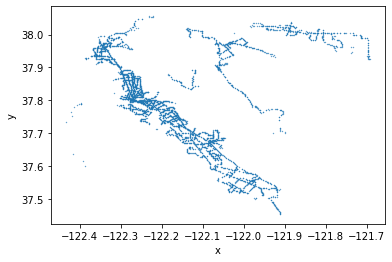

In [20]:
# Visualize the transit network

urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## Build Pedestrian Network

In [21]:
# Download OSM pedestrian street network data

nodes, edges = ua.osm.load.ua_network_from_bbox(bbox= region_bbox,
                                                remove_lcn=True)

Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.45395010,-122.44149296,37.78356365,-121.95314893);>;);out;'}"
Downloaded 85,953.0KB from www.overpass-api.de in 8.80 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.78023677,-122.44149296,38.10551771,-121.94852374);>;);out;'}"
Downloaded 77,090.3KB from www.overpass-api.de in 4.59 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedes

In [22]:
# Create a travel-time-weighted pedestrian network.
# It is automatically added to the same variable as the transit network

ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.02 seconds


<AxesSubplot:xlabel='x', ylabel='y'>

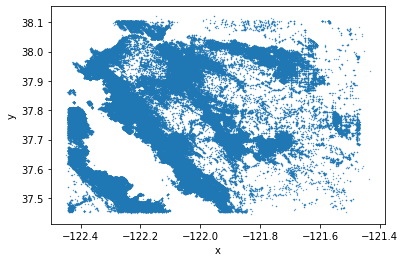

In [23]:
# Visualize the pedestrian network

urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## Integrate Transit + Pedestrian Networks

In [24]:
# Integrate the networks (still in our urbanaccess_net variable)

ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 4,617 nodes and 35,529 edges;
     OSM: 346,418 nodes and 971,278 edges
routes successfully joined to transit nodes. Took 0.05 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 1.96 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.03 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 10.55 seconds
Network edge and node network integration completed successfully resulting in a total of 352,324 nodes and 1,049,468 edges:
     Transit: 5,906 nodes 35,529 edges;
     OSM: 346,418 nodes 971,278 edges; and
     OSM/Transit connector: 42,661 edges.


Figure created. Took 61.97 seconds


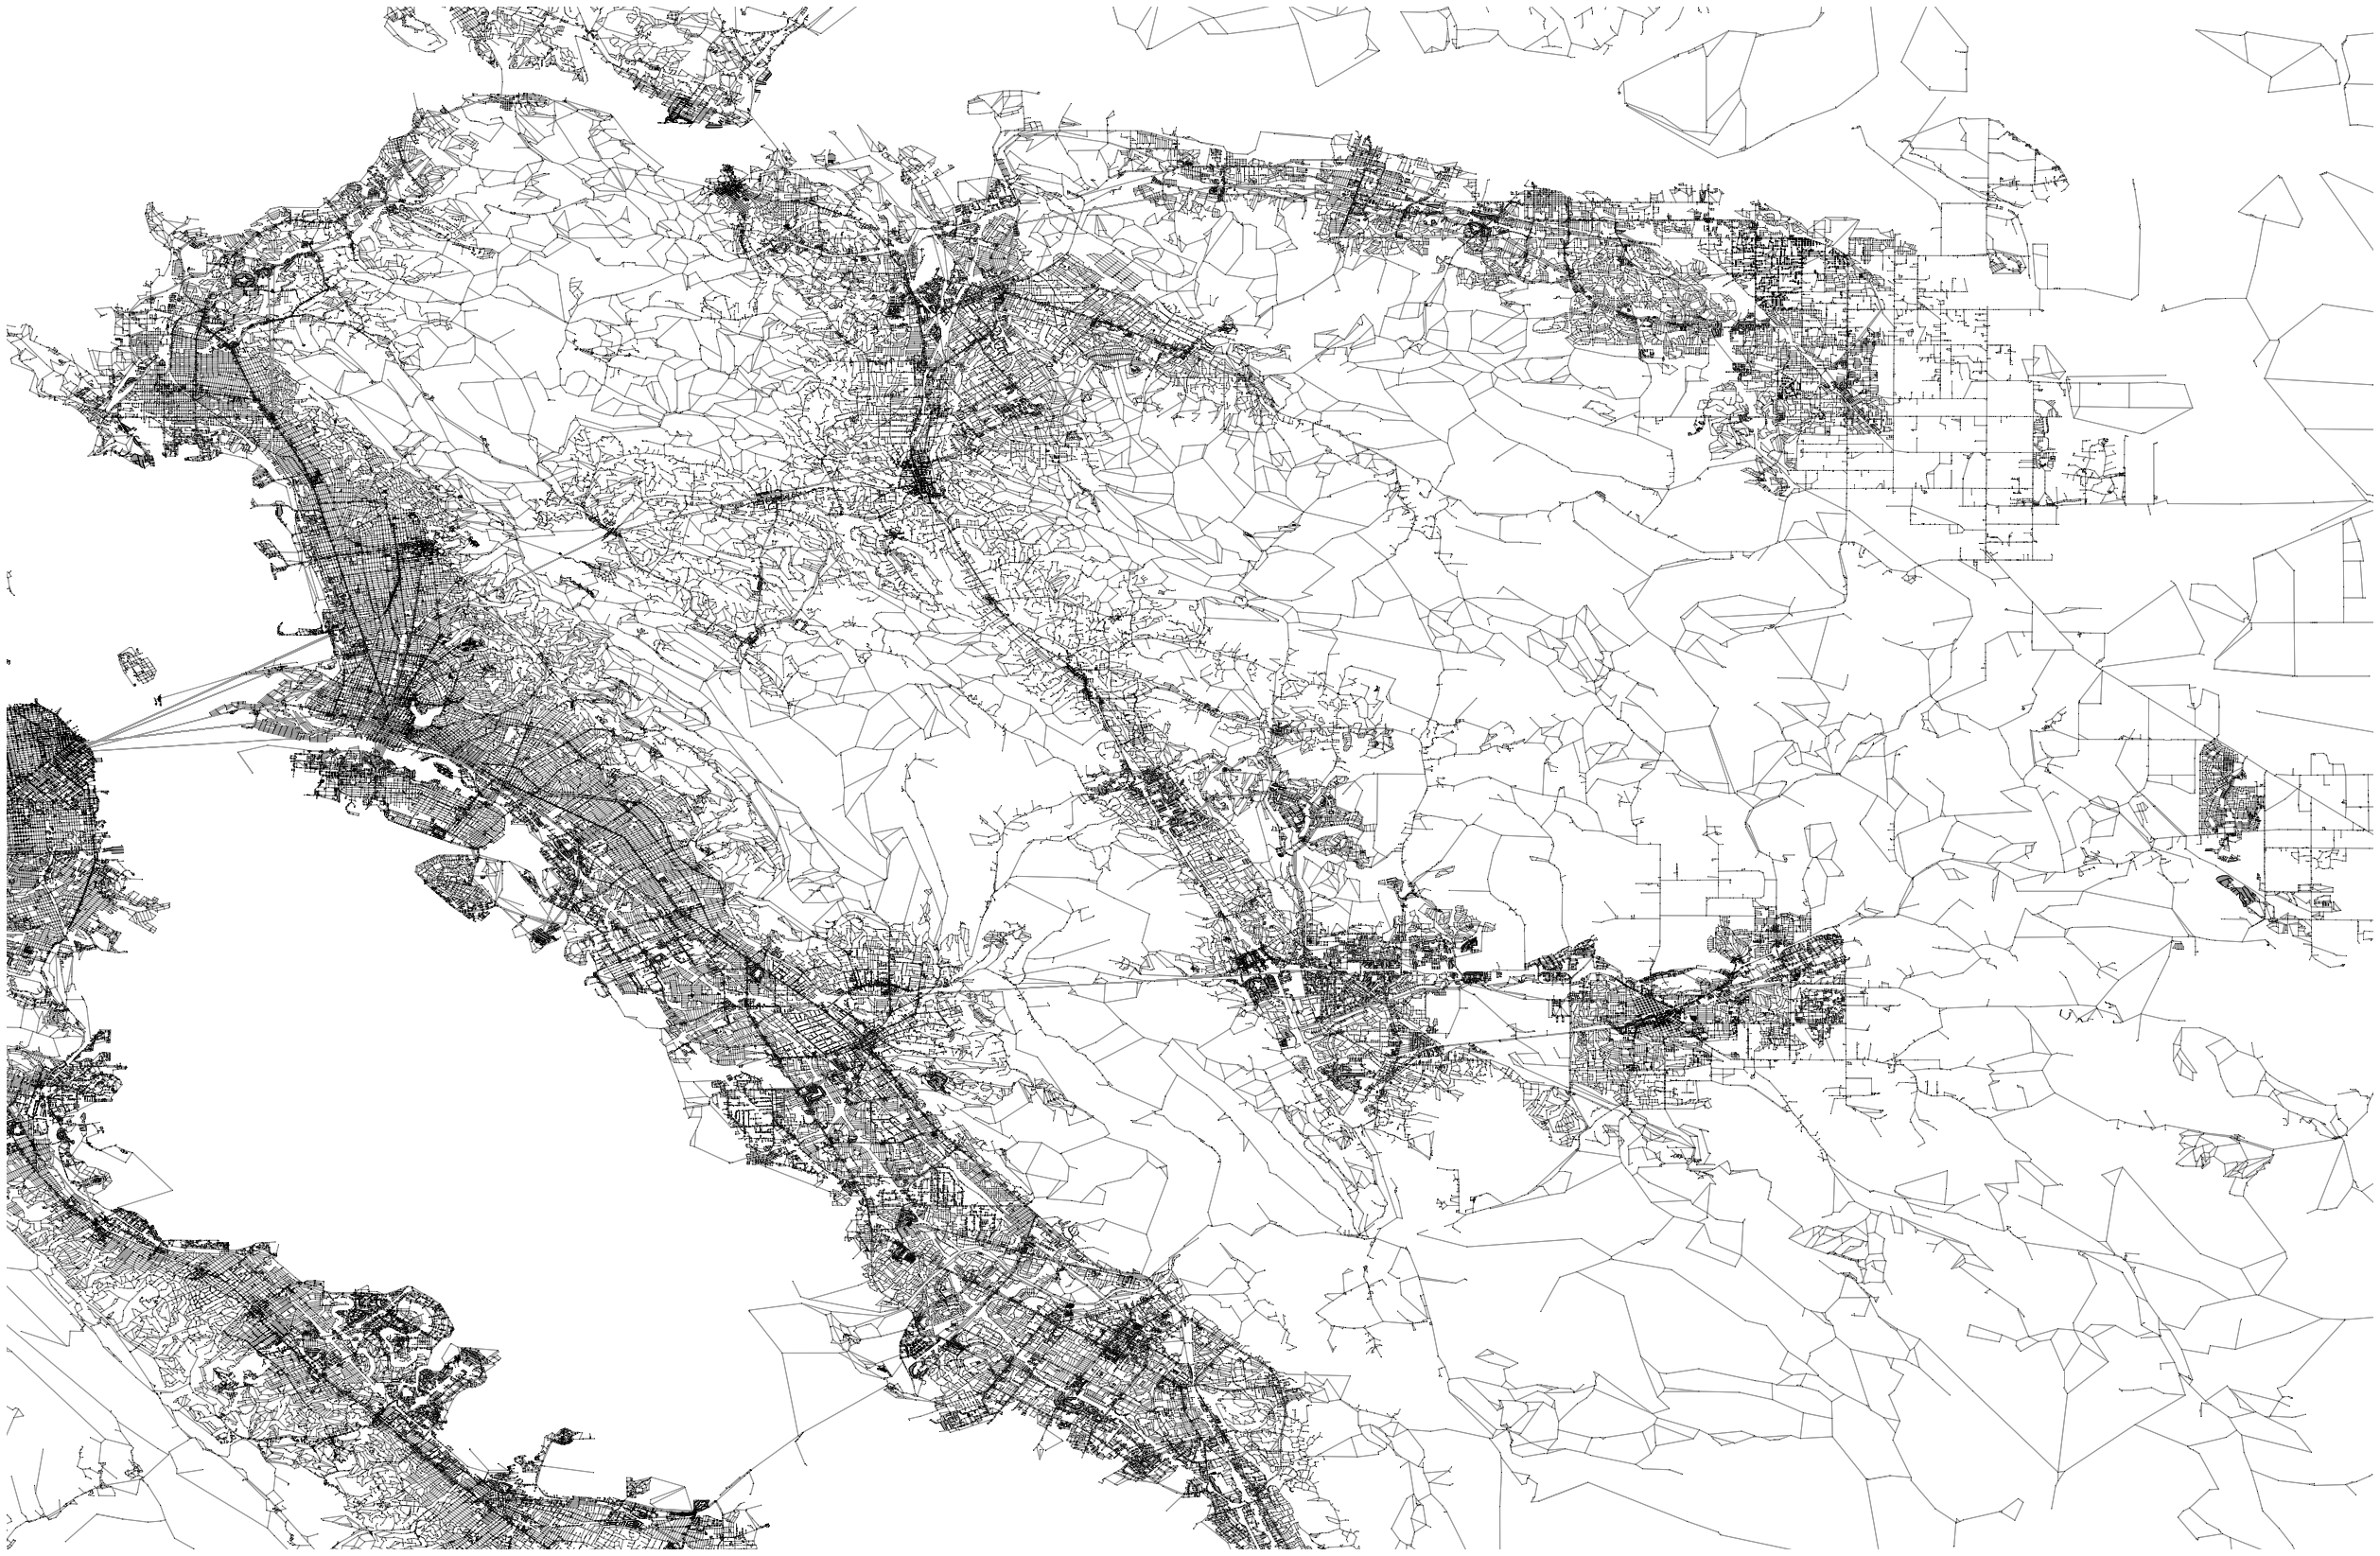

(<Figure size 3228.55x2160 with 1 Axes>, <AxesSubplot:>)

In [25]:
# Visualize the integrated network

ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=region_bbox,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=1.1, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

In [26]:
# # Save the network as an HDF5 file

# ua.network.save_network(urbanaccess_network=urbanaccess_net,
#                         filename='final_net.h5',
#                         overwrite_key = True)

In [27]:
# # Load the saved network from file

# urbanaccess_net = ua.network.load_network(filename='final_net.h5')

## Calculate Accessibility

In [28]:
# Initialize a pandana network

transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)

Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 352324
Setting CH edge vector of size 1049468
Range graph removed 1110306 edges of 2098936
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [29]:
# Read in the park entrance data

parks_df = gpd.read_file("data/park/Park_Entrances.shp")
print(parks_df.shape)
parks_df.head()

(268, 87)


OBJECTID_1              ENTR_TYPE                        PARK  \
0          14     Trail Staging Area                SF Bay Trail   
1          15           Staging Area  Carquinez Strait Shoreline   
2          32  Walk in Entrance/Gate  Carquinez Strait Shoreline   
3          33  Walk in Entrance/Gate  Carquinez Strait Shoreline   
4          34                Service  Carquinez Strait Shoreline   

                                     NAME  \
0  Pinole Shores Drive Trail Staging Area   
1                    Nejedly Staging Area   
2            Rankin Park Walk-In Entrance   
3          Foster Street Walk-In Entrance   
4           Wallin Drive Walk-In Entrance   

                                            SOURCE WALKING BIKING SWIM_POOL  \
0  Digitized MPeterson 7/08 (from Supvsr comments)       Y      Y         N   
1                          Digitized Khass 11/2006       Y      Y         N   
2                          Digitized Khass 11/2006       Y      Y         N   
3                          Digitized Khass 11/2006       Y      Y         N   
4                          Digitized Khass 11/2006       Y      Y         N   

  SWIM_LAKE DOG_WALK  ...            I_GCAMP            I_BPCAMP  \
0         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
1         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
2         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
3         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
4         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   

             I_FCAMP           LEGEND SLOOPHIKE  \
0  i_no_fcamp_35.gif  icon_legend.htm         N   
1  i_no_fcamp_35.gif  icon_legend.htm         N   
2  i_no_fcamp_35.gif  icon_legend.htm         N   
3  i_no_fcamp_35.gif  icon_legend.htm         N   
4  i_no_fcamp_35.gif  icon_legend.htm         N   

                                            PARK_MAP  \
0                                                n/a   
1  http://www.ebparks.org//civicax/filebank/blobd...   
2  http://www.ebparks.org//civicax/filebank/blobd...   
3  http://www.ebparks.org//civicax/filebank/blobd...   
4  http://www.ebparks.org//civicax/filebank/blobd...   

                                          ACTIVITIES      CITY       JPG  \
0                                 Sorry_no_Activ.htm    Pinole  0562.jpg   
1  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0005.jpg   
2  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0413.jpg   
3  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0415.jpg   
4                                 Sorry_no_Activ.htm  Martinez  0416.jpg   

                          geometry  
0  POINT (6039604.108 2195239.535)  
1  POINT (6087181.415 2197336.681)  
2  POINT (6087876.842 2196385.476)  
3  POINT (6088184.765 2196781.161)  
4  POINT (6090108.974 2189505.416)  

[5 rows x 87 columns]

In [30]:
# Check the crs

parks_df.crs

<Projected CRS: EPSG:2227>
Name: NAD83 / California zone 3 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Alameda; Calaveras; Contra Costa; Madera; Marin; Mariposa; Merced; Mono; San Francisco; San Joaquin; San Mateo; Santa Clara; Santa Cruz; Stanislaus; Tuolumne.
- bounds: (-123.02, 36.73, -117.83, 38.71)
Coordinate Operation:
- name: SPCS83 California zone 3 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [31]:
# Reproject the park entrance data for use with the UrbanAccess network

parks_df = parks_df.to_crs("EPSG:4326")
parks_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
parks_df.head()

OBJECTID_1              ENTR_TYPE                        PARK  \
0          14     Trail Staging Area                SF Bay Trail   
1          15           Staging Area  Carquinez Strait Shoreline   
2          32  Walk in Entrance/Gate  Carquinez Strait Shoreline   
3          33  Walk in Entrance/Gate  Carquinez Strait Shoreline   
4          34                Service  Carquinez Strait Shoreline   

                                     NAME  \
0  Pinole Shores Drive Trail Staging Area   
1                    Nejedly Staging Area   
2            Rankin Park Walk-In Entrance   
3          Foster Street Walk-In Entrance   
4           Wallin Drive Walk-In Entrance   

                                            SOURCE WALKING BIKING SWIM_POOL  \
0  Digitized MPeterson 7/08 (from Supvsr comments)       Y      Y         N   
1                          Digitized Khass 11/2006       Y      Y         N   
2                          Digitized Khass 11/2006       Y      Y         N   
3                          Digitized Khass 11/2006       Y      Y         N   
4                          Digitized Khass 11/2006       Y      Y         N   

  SWIM_LAKE DOG_WALK  ...            I_GCAMP            I_BPCAMP  \
0         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
1         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
2         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
3         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   
4         N        Y  ...  i_no_gcamp_35.gif  i_no_bpcamp_35.gif   

             I_FCAMP           LEGEND SLOOPHIKE  \
0  i_no_fcamp_35.gif  icon_legend.htm         N   
1  i_no_fcamp_35.gif  icon_legend.htm         N   
2  i_no_fcamp_35.gif  icon_legend.htm         N   
3  i_no_fcamp_35.gif  icon_legend.htm         N   
4  i_no_fcamp_35.gif  icon_legend.htm         N   

                                            PARK_MAP  \
0                                                n/a   
1  http://www.ebparks.org//civicax/filebank/blobd...   
2  http://www.ebparks.org//civicax/filebank/blobd...   
3  http://www.ebparks.org//civicax/filebank/blobd...   
4  http://www.ebparks.org//civicax/filebank/blobd...   

                                          ACTIVITIES      CITY       JPG  \
0                                 Sorry_no_Activ.htm    Pinole  0562.jpg   
1  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0005.jpg   
2  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0413.jpg   
3  https://apm.activecommunities.com/ebparks/Acti...  Martinez  0415.jpg   
4                                 Sorry_no_Activ.htm  Martinez  0416.jpg   

                      geometry  
0  POINT (-122.31215 38.00988)  
1  POINT (-122.14717 38.01806)  
2  POINT (-122.14470 38.01548)  
3  POINT (-122.14365 38.01658)  
4  POINT (-122.13653 37.99669)  

[5 rows x 87 columns]

<AxesSubplot:>

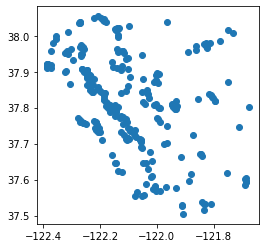

In [33]:
parks_df.plot()

In [34]:
# select the nodes in the network where parks are located

node_ids = transit_ped_net.get_node_ids(parks_df['geometry'].x, parks_df['geometry'].y)

In [35]:
# set a variable related to the park nodes in the network

transit_ped_net.set(node_ids, name='parks')

In [36]:
# # calculate the variable for every origin node in the network
# # as the number of park nodes within a maximum distance of it

# maxdist = 30

# access = transit_ped_net.aggregate(maxdist,
#                            type='count',
#                            decay='linear',
#                            name='parks'
#                           )

# # Cap the variable at 5 parks
# access= access.clip(upper=5)

# access.describe()

In [37]:
# # plot the number of parks within the maximum distance
# # of each node in the network

# fig = plt.subplots(figsize=(20,20))

# data_crs = ccrs.PlateCarree()
# ax = plt.axes(projection=ccrs.epsg(26943))
# ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

# plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
#             c=access, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
# cb = plt.colorbar()

In [38]:
# set the park entrance locations on the network

# The units are minutes of travel time
maxdist = 200

transit_ped_net.set_pois(category='park',
                 maxdist=maxdist,
                 maxitems=1,
                 x_col=parks_df['geometry'].x, 
                 y_col=parks_df['geometry'].y)

In [39]:
# calculate travel time to nearest park entrance from each node in network

distances = transit_ped_net.nearest_pois(distance=maxdist,
                                         category='park',
                                         num_pois=1
                                        )
distances.astype(int).head()

1
id_int    
1       21
2       19
3       17
4       17
5       22

In [40]:
# Visualize travel time to the nearest park entrance from each node on the network
# Limited to nodes that are within 200 mins max travel time.

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=distances[1], s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

## Format the output as a spatial data layer

In [41]:
# Create a GeoDataFrame with the location of each
# origin node in the network and the
# distance to the nearest park entrance

# Extract the locations of the origin nodes in the network
geometry = gpd.points_from_xy(x = transit_ped_net.nodes_df['x'],
                              y = transit_ped_net.nodes_df['y'])

# Create the GeoDataFrame with the distance data
distances_gdf = gpd.GeoDataFrame(distances[1], geometry=geometry)

# Clean up the GDF columns, index, and crs
distances_gdf.rename(columns={1:'distance'}, inplace=True)
distances_gdf.reset_index(drop=True, inplace=True)
distances_gdf.crs = "EPSG:4326"

print(distances_gdf.shape)
distances_gdf.head()

(352324, 2)


distance                     geometry
0  21.712999  POINT (-122.26857 37.87031)
1  19.080000  POINT (-122.27517 37.87141)
2  17.580000  POINT (-122.28028 37.87074)
3  17.983999  POINT (-122.28208 37.87007)
4  22.021000  POINT (-122.28180 37.86710)

In [42]:
# Save as a GeoJSON file

distances_gdf.to_file("data/transit_distance.geojson", driver='GeoJSON')